In [1]:
# Math libraries
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess data
from sklearn.preprocessing import StandardScaler

# All models to use
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

# Read datasets

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,last_checkout_day_log,open_count_last_10_days_log,open_count_last_30_days_log,open_count_last_60_days_log,login_count_last_10_days_log,login_count_last_30_days_log,login_count_last_60_days_log,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,...,2.944439,0.000000,1.098612,1.609438,2.564949,3.784190,4.605170,0.000000,1.791759,2.397895
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,...,2.197225,1.098612,2.302585,2.890372,2.944439,3.891820,4.510860,0.693147,0.693147,1.609438
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,...,1.791759,0.000000,1.609438,2.564949,3.218876,4.248495,4.787492,1.791759,2.995732,3.332205
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,...,3.988984,0.000000,0.000000,0.693147,2.302585,3.178054,4.248495,0.693147,1.386294,1.945910
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,...,5.402677,0.000000,0.000000,0.000000,1.098612,1.791759,1.791759,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71534,6,2019-09-02 00:00:00+08:00,127613,39,24,36,279,0,1,1,...,5.634790,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71535,2,2019-09-02 00:00:00+08:00,127620,38,46,10,51,0,0,1,...,3.951244,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71536,2,2019-09-02 00:00:00+08:00,127696,32,808,18141,1445,0,0,0,...,7.276556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71537,2,2019-09-02 00:00:00+08:00,127807,38,5,34,1445,2,4,4,...,7.276556,1.098612,1.609438,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
train.columns

Index(['country_code', 'grass_date', 'user_id', 'subject_line_length',
       'last_open_day', 'last_login_day', 'last_checkout_day',
       'open_count_last_10_days', 'open_count_last_30_days',
       'open_count_last_60_days', 'login_count_last_10_days',
       'login_count_last_30_days', 'login_count_last_60_days',
       'checkout_count_last_10_days', 'checkout_count_last_30_days',
       'checkout_count_last_60_days', 'open_flag', 'row_id', 'attr_1',
       'attr_2', 'attr_3', 'age', 'domain', 'day_of_week', 'user_id_count',
       'age_group', 'weekend', 'last_open_day_log', 'last_login_day_log',
       'last_checkout_day_log', 'open_count_last_10_days_log',
       'open_count_last_30_days_log', 'open_count_last_60_days_log',
       'login_count_last_10_days_log', 'login_count_last_30_days_log',
       'login_count_last_60_days_log', 'checkout_count_last_10_days_log',
       'checkout_count_last_30_days_log', 'checkout_count_last_60_days_log'],
      dtype='object')

# Balance the training set

open_flag
0    61083
1    10456
Name: country_code, dtype: int64


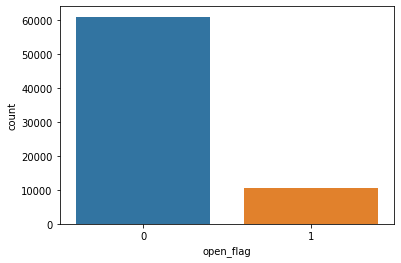

In [4]:
sns.countplot('open_flag', data=train)
print(train.groupby('open_flag').count()['country_code'])

Class `0` will be undersampled, while class `1` will be oversampled

open_flag
0    30000
1    30000
Name: country_code, dtype: int64


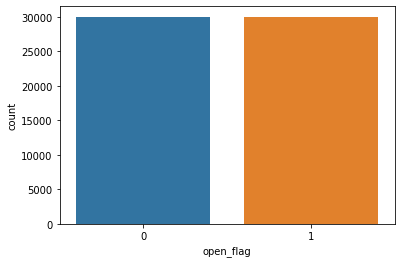

In [5]:
TRAIN_SIZE = 30000

df0 = train[train['open_flag'] == 0]
df0 = df0.sample(TRAIN_SIZE, random_state=0)

df1 = train[train['open_flag'] == 1]
df1 = df1.append(df1, ignore_index=True)
df1 = df1.append(df1, ignore_index=True)
df1 = df1.sample(TRAIN_SIZE, random_state=0)

train_resampled = pd.concat((df0, df1), ignore_index=True)

sns.countplot('open_flag', data=train_resampled)
print(train_resampled.groupby('open_flag').count()['country_code'])

# Target encoder

Encode categorical features to numerical values, based on their frequencies of having `open_flag=1`

In [6]:
def target_encoder(df, feature, label):
    ranking = df.groupby(feature).apply(lambda x: x[label].sum() / x[label].count())
    ranking = ranking.sort_values()

    encoder = {x: i for i, x in enumerate(ranking.index)}
    decoder = {i: x for i, x in enumerate(ranking.index)}
    return encoder, decoder

target_encoder(train_resampled, 'country_code', 'open_flag')

({1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6},
 {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4})

In [7]:
all_encoders = {}
all_decoders = {}

for x in ['country_code', 'domain', 'day_of_week']:
    encoder, decoder = target_encoder(train, x, 'open_flag')
    all_encoders[x] = encoder
    all_decoders[x] = decoder

    train_resampled[x + '_encoded'] = train_resampled[x].map(encoder)
    test[x + '_encoded'] = test[x].map(encoder)

print(all_encoders)
print(all_decoders)

{'country_code': {1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6}, 'domain': {'@gmail.com': 0, '@163.com': 1, '@yahoo.com': 2, '@ymail.com': 3, '@rocketmail.com': 4, '@outlook.com': 5, '@qq.com': 6, '@live.com': 7, '@icloud.com': 8, '@hotmail.com': 9, 'other': 10}, 'day_of_week': {5: 0, 1: 1, 0: 2, 3: 3, 6: 4, 4: 5, 2: 6}}
{'country_code': {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4}, 'domain': {0: '@gmail.com', 1: '@163.com', 2: '@yahoo.com', 3: '@ymail.com', 4: '@rocketmail.com', 5: '@outlook.com', 6: '@qq.com', 7: '@live.com', 8: '@icloud.com', 9: '@hotmail.com', 10: 'other'}, 'day_of_week': {0: 5, 1: 1, 2: 0, 3: 3, 4: 6, 5: 4, 6: 2}}


# Features engineering

In [8]:
OLC = ('open', 'login', 'checkout')
DAYS = (10, 30, 60)

for x in DAYS:
    train_resampled[f'engine{x}'] = (train_resampled[f'checkout_count_last_{x}_days'] + 1) / (train_resampled[f'login_count_last_{x}_days'] + 1)
    test[f'engine{x}'] = (test[f'checkout_count_last_{x}_days'] + 1) / (test[f'login_count_last_{x}_days'] + 1)

for x in OLC:
    train_resampled[f'engine{x}1'] = train_resampled[f'{x}_count_last_30_days'] - train_resampled[f'{x}_count_last_10_days']
    train_resampled[f'engine{x}2'] = train_resampled[f'{x}_count_last_60_days'] - train_resampled[f'{x}_count_last_30_days']
    test[f'engine{x}1'] = test[f'{x}_count_last_30_days'] - test[f'{x}_count_last_10_days']
    test[f'engine{x}2'] = test[f'{x}_count_last_60_days'] - test[f'{x}_count_last_30_days']

In [9]:
encoded_features = \
    ['subject_line_length'] + \
    [f'last_{x}_day' for x in OLC] + \
    [f'last_{x}_day_log' for x in OLC] + \
    [f'{x}_count_last_{y}_days' for x in OLC for y in DAYS] + \
    [f'{x}_count_last_{y}_days_log' for x in OLC for y in DAYS] + \
    ['engine10', 'engine30', 'engine60',
    'attr_1', 'attr_2', 'attr_3',
    'country_code_encoded', 'domain_encoded', 'day_of_week_encoded',
    'user_id_count', 'age', 'age_group',
    'weekend']

In [10]:
len(encoded_features)

38

# Correlation matrix

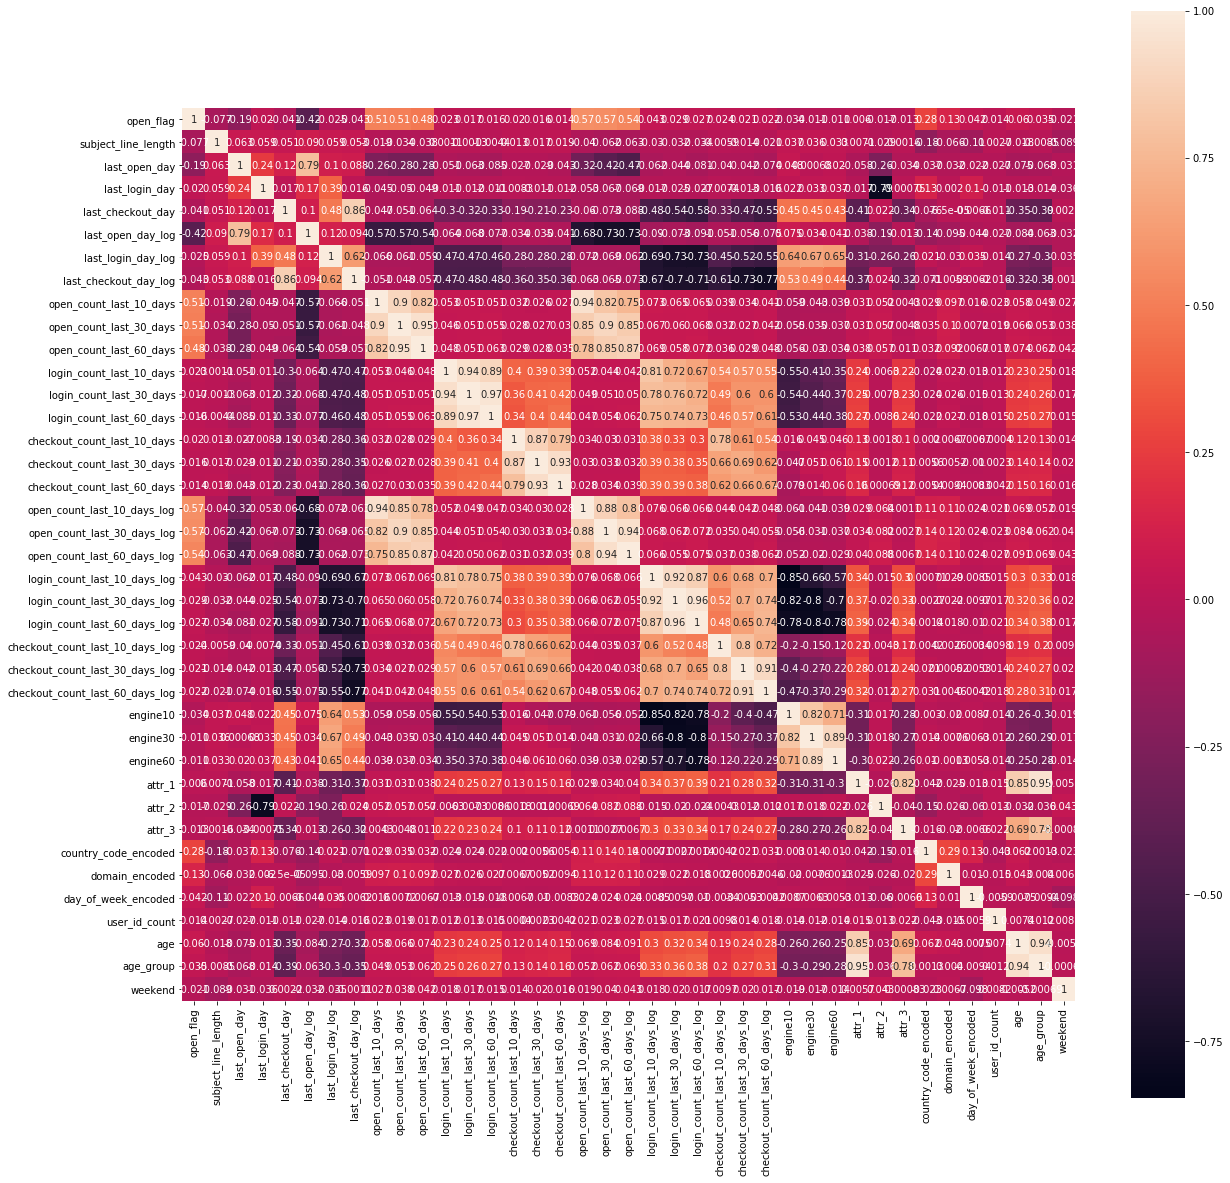

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(
    train_resampled.loc[:, ['open_flag'] + encoded_features].corr(), 
    square=True, annot=True
)

# Prepare data for training and evaluation

Extract inputs and labels

In [12]:
inputs = train_resampled.loc[:, encoded_features]
test_inputs = test.loc[:, encoded_features]

labels = train_resampled['open_flag']
test_labels = test['open_flag']

Use standard scaler to scale the data

In [13]:
scale = StandardScaler()
inputs = scale.fit_transform(inputs)
test_inputs = scale.transform(test_inputs)

inputs

array([[-0.45444207, -0.20069689, -0.10842723, ...,  0.89673015,
         1.09331025, -0.50660613],
       [ 0.17346336, -0.336412  , -0.10692654, ...,  0.53220781,
         0.5173786 ,  1.97392005],
       [-0.18533974, -0.17261791, -0.10767689, ...,  0.37598396,
         0.5173786 , -0.50660613],
       ...,
       [-0.7235444 , -0.38789014, -0.10767689, ...,  1.57370019,
         1.6692419 , -0.50660613],
       [-0.18533974, -0.38789014, -0.097172  , ..., -1.08210538,
        -1.21041635, -0.50660613],
       [-0.00593819, -0.3223725 ,  0.04914599, ...,  1.78199867,
         1.6692419 , -0.50660613]])

# Model training and evaluation

Four models are used:
- Random Forest
- Gradient Boosting
- XGBoost
- CatBoost

In [14]:
def test_model(model, inputs, labels, test_inputs, test_labels):
    print('Training model...')
    model.fit(inputs, labels)
    preds = model.predict(test_inputs)

    sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt="d")
    print('Test accuracy: ', accuracy_score(test_labels, preds))
    print('Test Matthews: ', matthews_corrcoef(test_labels, preds))

Training model...
Test accuracy:  0.7705
Test Matthews:  0.5637132656699698


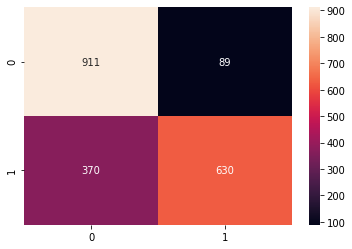

In [15]:
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
test_model(forest, inputs, labels, test_inputs, test_labels)

Training model...
Test accuracy:  0.796
Test Matthews:  0.5936275835443509


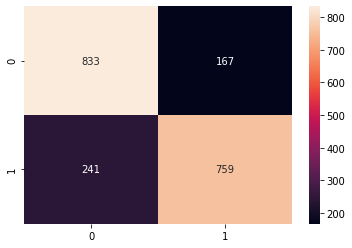

In [16]:
gbc_forest = GradientBoostingClassifier()
test_model(gbc_forest, inputs, labels, test_inputs, test_labels)

Training model...
Test accuracy:  0.796
Test Matthews:  0.5947469374813408


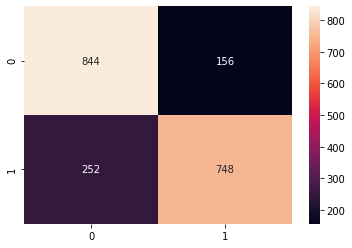

In [17]:
xgb_forest = XGBClassifier()
test_model(xgb_forest, inputs, labels, test_inputs, test_labels)

Training model...
Test accuracy:  0.804
Test Matthews:  0.6094105898148707


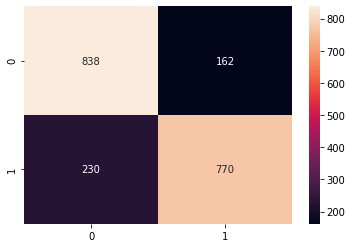

In [18]:
cbc_forest = CatBoostClassifier(task_type='GPU', verbose=0)
test_model(cbc_forest, inputs, labels, test_inputs, test_labels)


In [19]:
df = pd.DataFrame()
df['forest'] = forest.predict_proba(test_inputs)[:, 1]
df['gbc'] = gbc_forest.predict_proba(test_inputs)[:, 1]
df['xgb_forest'] = xgb_forest.predict_proba(test_inputs)[:, 1]
df['cat_clf'] = cbc_forest.predict_proba(test_inputs)[:, 1]
df['all'] = df.mean(axis=1)
df

,forest,gbc,xgb_forest,cat_clf,all
0,0.111,0.167139,0.039215,0.127994,0.111337
1,0.539,0.745660,0.491471,0.655481,0.607903
2,0.105,0.450117,0.226851,0.323074,0.276261
3,0.572,0.730073,0.549440,0.675399,0.631728
4,0.500,0.561891,0.486271,0.534767,0.520732
...,...,...,...,...,...
1995,0.493,0.701428,0.732719,0.737358,0.666126
1996,0.860,0.921392,0.955322,0.951892,0.922151
1997,0.355,0.255684,0.263412,0.390161,0.316064
1998,0.373,0.261709,0.620075,0.502810,0.439399


Test accuracy:  0.7965
Test Matthews:  0.5983154116164966


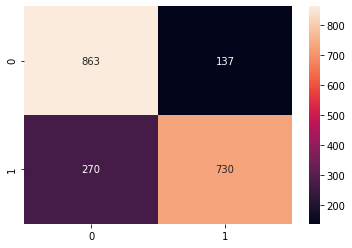

In [20]:
preds = (df['all'] >= 0.5).astype(int).to_numpy()

print('Test accuracy: ', accuracy_score(test_labels, preds))
print('Test Matthews: ', matthews_corrcoef(test_labels, preds))
sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt="d")

# Import and process test set for submission

In [21]:
kaggle_test = pd.read_csv('test_kaggle.csv')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,last_checkout_day_log,open_count_last_10_days_log,open_count_last_30_days_log,open_count_last_60_days_log,login_count_last_10_days_log,login_count_last_30_days_log,login_count_last_60_days_log,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,2.639057,1.098612,1.386294,1.609438,2.397895,3.555348,4.905275,0.000000,1.945910,2.944439
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,5.950643,0.693147,0.693147,0.693147,1.791759,1.791759,1.791759,0.000000,0.000000,0.000000
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.386294,0.000000,0.000000,0.000000,2.639057,2.995732,3.663562,1.098612,1.098612,1.098612
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.791759,0.000000,0.000000,0.000000,3.784190,4.709530,5.159055,1.098612,1.791759,1.791759
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,4.007333,0.000000,0.000000,0.000000,1.609438,2.564949,3.688879,0.000000,0.000000,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,2.197225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,7.096721,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,7.276556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.945910,1.098612,1.791759,2.708050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
for feature, encoder in all_encoders.items():
    kaggle_test[feature + '_encoded'] = kaggle_test[feature].map(encoder)

for x in ['10', '30', '60']:
    kaggle_test['engine' + x] = (kaggle_test[f'checkout_count_last_{x}_days'] + 1) / (kaggle_test[f'login_count_last_{x}_days'] + 1)

for x in OLC:
    kaggle_test[f'engine{x}1'] = kaggle_test[f'{x}_count_last_30_days'] - kaggle_test[f'{x}_count_last_10_days']
    kaggle_test[f'engine{x}2'] = kaggle_test[f'{x}_count_last_60_days'] - kaggle_test[f'{x}_count_last_30_days']

kaggle_inputs = kaggle_test.loc[:, encoded_features]
kaggle_inputs = scale.transform(kaggle_inputs)

# Use the trained models to predict the test set

In [23]:
def predict_kaggle(model, name=''):
    kaggle_preds = model.predict(kaggle_inputs)
    kaggle_test['open_flag'] = kaggle_preds
    kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv(f'submission_{name}.csv', index=False)

In [24]:
predict_kaggle(forest, 'forest')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,engine10,engine30,engine60,engineopen1,engineopen2,enginelogin1,enginelogin2,enginecheckout1,enginecheckout2,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.090909,0.200000,0.140741,1,1,24,100,6,12,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.166667,0.166667,0.166667,0,0,0,0,0,0,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,0.214286,0.150000,0.076923,0,0,6,19,0,0,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,0.068182,0.054054,0.034483,0,0,67,63,3,0,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.200000,0.076923,0.075000,0,0,8,27,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,1.000000,1.000000,1.000000,0,1,0,0,0,0,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.000000,1.000000,1.000000,3,9,0,0,0,0,1


In [25]:
predict_kaggle(gbc_forest, 'gbc_forest')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,engine10,engine30,engine60,engineopen1,engineopen2,enginelogin1,enginelogin2,enginecheckout1,enginecheckout2,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.090909,0.200000,0.140741,1,1,24,100,6,12,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.166667,0.166667,0.166667,0,0,0,0,0,0,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,0.214286,0.150000,0.076923,0,0,6,19,0,0,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,0.068182,0.054054,0.034483,0,0,67,63,3,0,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.200000,0.076923,0.075000,0,0,8,27,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,1.000000,1.000000,1.000000,0,1,0,0,0,0,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.000000,1.000000,1.000000,3,9,0,0,0,0,1


In [26]:
predict_kaggle(xgb_forest, 'xgb_forest')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,engine10,engine30,engine60,engineopen1,engineopen2,enginelogin1,enginelogin2,enginecheckout1,enginecheckout2,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.090909,0.200000,0.140741,1,1,24,100,6,12,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.166667,0.166667,0.166667,0,0,0,0,0,0,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,0.214286,0.150000,0.076923,0,0,6,19,0,0,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,0.068182,0.054054,0.034483,0,0,67,63,3,0,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.200000,0.076923,0.075000,0,0,8,27,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,1.000000,1.000000,1.000000,0,1,0,0,0,0,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.000000,1.000000,1.000000,3,9,0,0,0,0,1


In [27]:
predict_kaggle(cbc_forest, 'cbc_forest')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,engine10,engine30,engine60,engineopen1,engineopen2,enginelogin1,enginelogin2,enginecheckout1,enginecheckout2,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.090909,0.200000,0.140741,1,1,24,100,6,12,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.166667,0.166667,0.166667,0,0,0,0,0,0,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,0.214286,0.150000,0.076923,0,0,6,19,0,0,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,0.068182,0.054054,0.034483,0,0,67,63,3,0,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.200000,0.076923,0.075000,0,0,8,27,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,1.000000,1.000000,1.000000,0,1,0,0,0,0,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.000000,1.000000,1.000000,3,9,0,0,0,0,1


# Model ensemble

Combine probabilities output from all models

In [28]:
df = pd.DataFrame()
df['forest'] = forest.predict_proba(kaggle_inputs)[:, 1]
df['gbc'] = gbc_forest.predict_proba(kaggle_inputs)[:, 1]
df['xgb_forest'] = xgb_forest.predict_proba(kaggle_inputs)[:, 1]
df['cat_clf'] = cbc_forest.predict_proba(kaggle_inputs)[:, 1]
df

,forest,gbc,xgb_forest,cat_clf
0,0.727,0.701433,0.819506,0.717122
1,0.360,0.434880,0.507346,0.523953
2,0.192,0.227370,0.109887,0.200327
3,0.069,0.124580,0.090641,0.075949
4,0.169,0.260621,0.298204,0.259887
...,...,...,...,...
55965,0.168,0.200629,0.148557,0.166861
55966,0.200,0.201635,0.119228,0.168836
55967,0.123,0.184694,0.113332,0.114223
55968,0.698,0.829082,0.690830,0.711132


In [29]:
df['all'] = df.mean(axis=1)
df

,forest,gbc,xgb_forest,cat_clf,all
0,0.727,0.701433,0.819506,0.717122,0.741266
1,0.360,0.434880,0.507346,0.523953,0.456545
2,0.192,0.227370,0.109887,0.200327,0.182396
3,0.069,0.124580,0.090641,0.075949,0.090042
4,0.169,0.260621,0.298204,0.259887,0.246928
...,...,...,...,...,...
55965,0.168,0.200629,0.148557,0.166861,0.171012
55966,0.200,0.201635,0.119228,0.168836,0.172424
55967,0.123,0.184694,0.113332,0.114223,0.133812
55968,0.698,0.829082,0.690830,0.711132,0.732261


In [30]:
kaggle_test['open_flag'] = (df['all'] >= 0.5).astype(int)
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission_ensemble.csv', index=False)
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,engine10,engine30,engine60,engineopen1,engineopen2,enginelogin1,enginelogin2,enginecheckout1,enginecheckout2,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.090909,0.200000,0.140741,1,1,24,100,6,12,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.166667,0.166667,0.166667,0,0,0,0,0,0,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,0.214286,0.150000,0.076923,0,0,6,19,0,0,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,0.068182,0.054054,0.034483,0,0,67,63,3,0,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.200000,0.076923,0.075000,0,0,8,27,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,1.000000,1.000000,1.000000,0,1,0,0,0,0,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,1.000000,1.000000,1.000000,0,0,0,0,0,0,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,1.000000,1.000000,1.000000,3,9,0,0,0,0,1
